In [45]:
from convokit import Corpus, Conversation, Utterance, Speaker, FightingWords, download
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

## 1. Data Pre-Processing

In [2]:
# Same as Checkpoint 1:
# Filter for the years of the Supreme Court Case corpus that are a part
# of the Rehnquist 7 and Roberts 4 natural courts

rehnquist_years = [i for i in range(1994,2006)]
rehnquist_corpus = None
for year in rehnquist_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not rehnquist_corpus:
        rehnquist_corpus = corp
    else:
        rehnquist_corpus = Corpus.merge(rehnquist_corpus, corp)

roberts_years = [i for i in range(2010,2017)]
roberts_corpus = None
for year in roberts_years:
    corp = Corpus(filename=download(f"supreme-{year}"))
    if not roberts_corpus:
        roberts_corpus = corp
    else:
        roberts_corpus = Corpus.merge(roberts_corpus, corp)


# Using the start and end dates of both natural courts, filter for the
# relevant case ids, removing cases belonging to the previous or the following courts
with open('../data/cases.json', "r") as f:
    data = [json.loads(line) for line in f]
    begin_date_rehn7 = datetime.strptime('Aug 3, 1994', '%b %d, %Y')
    end_date_rehn7 = datetime.strptime('Sep 28, 2005','%b %d, %Y')
    begin_date_rob4 = datetime.strptime('Aug 7, 2010', '%b %d, %Y')
    end_date_rob4 = datetime.strptime('Feb 13, 2016', '%b %d, %Y')
    case_ids_rehn7 = []
    case_ids_rob4 = []
    for case in data:
        str_date = case["decided_date"]
        if isinstance(str_date, str):
            num_date = datetime.strptime(str_date, '%b %d, %Y')
            if num_date >= begin_date_rehn7 and num_date <= end_date_rehn7:
                case_ids_rehn7.append(case["id"])
            if num_date >= begin_date_rob4 and num_date <= end_date_rob4:
                case_ids_rob4.append(case["id"])
with open('../data/filtered_cases.json', "w") as f2:
    json.dump({"rehn7": case_ids_rehn7,"rob4": case_ids_rob4}, f2, indent=1)

rehnquist_corpus = rehnquist_corpus.filter_conversations_by(lambda u: str(u.meta["case_id"]) in case_ids_rehn7) # complete rehnquist 7 court corpus
roberts_corpus = roberts_corpus.filter_conversations_by(lambda u: u.meta["case_id"] in case_ids_rob4) # complete roberts 4 court corpus

Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1994
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1995
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1996
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1997
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1998
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-1999
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2000
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2001
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2002
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2003
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2004
Dataset already exists at /Users/diamondunlap/.convokit/downloads/supreme-2005
Dataset already exists at /Users/diamondunlap/.convo

In [3]:
# Get the conversation dataframe for each court
rehnquist_convo_df = rehnquist_corpus.get_conversations_dataframe()
roberts_convo_df = roberts_corpus.get_conversations_dataframe()

# Use meta.win_side to split each conversation dataframe into 
# wins (1) - petitioning party received a favorable disposition, and
# losses (0) - no favorable disposition for petitioning party
rehnquist_wins_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 1, :]
rehnquist_losses_df = rehnquist_convo_df.loc[rehnquist_convo_df.loc[:, 'meta.win_side'] == 0, :]

roberts_wins_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 1, :]
roberts_losses_df = roberts_convo_df.loc[roberts_convo_df.loc[:, 'meta.win_side'] == 0, :]

In [4]:
display(roberts_convo_df)

,vectors,meta.case_id,meta.advocates,meta.win_side,meta.votes_side
id,,,,,
22372,[],2010_09-479,"{'david_l_horan': {'side': 1, 'role': 'for the...",0,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia..."
21694,[],2010_10-174,"{'peter_d_keisler': {'side': 1, 'role': 'for t...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
22462,[],2010_09-987,"{'neal_kumar_katyal': {'side': 2, 'role': 'Act...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
21834,[],2010_10-238,"{'william_r_maurer': {'side': 1, 'role': 'for ...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
23016,[],2010_10-98,"{'neal_kumar_katyal': {'side': 1, 'role': 'Act...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
...,...,...,...,...,...
24014,[],2015_14-723,"{'peter_k_stris': {'side': 1, 'role': 'for the...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
24003,[],2015_14-280,"{'richard_d_bernstein': {'side': 2, 'role': 'f...",1,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia..."
24018,[],2015_14-1095,"{'erik_s_jaffe': {'side': 1, 'role': 'for the ...",0,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia..."


## Baseline Setting
Before beginning the process to create predictions, we establish a baseline to help us evaluate our model's performance. In both courts, the majority of case outcomes is 1 - petitioning party received a favorable disposition: slightly above 60% of both court outcomes. The fact that there is not a perfect 50/50 split between win (1) and lose (0) outcomes is not surprising since the Supreme Court selects cases to hear. This likely biases the Supreme Court to take more cases where the Court has an interest in overturning a lower court's decision. Conversely, the Supreme Court would be less likely to select cases where a lower court's existing decision would simply be upheld or affirmed.

### Findings
We found that for the Rehnquist 7 Court, there are a total of 862 cases, 543 of which had an outcome of 1. This means that if we were to predict a win (1) for every case, we would be correct 63% of the time.

For the Roberts 4 Court there are a total of 351 cases, 225 of which won. If we were to perdict a win (1) for every case, we would be correct 64% of the time. 

Therefore our model will need to perform at these baselines or better. 

In [5]:
# Calculate baseline probabilities: identify the majority outcome
# for each court and the probability of that outcome

# Rehnquist 7 Court baseline: 543/862 = ~ 63%
# Roberts 4 Court baseline: 225/351 = ~ 64%
rehn7_outcome_count = rehnquist_convo_df.groupby('meta.case_id', as_index=True).agg({'meta.win_side': 'max'}).loc[: 'meta.win_side'].value_counts()
rob4_outcome_count = roberts_convo_df.groupby('meta.case_id', as_index=True).agg({'meta.win_side': 'max'}).loc[: 'meta.win_side'].value_counts()

print(rehn7_outcome_count)
print(rob4_outcome_count)

meta.win_side
1.0              543
0.0              318
2.0                1
dtype: int64
meta.win_side
1                225
0                126
dtype: int64


### Data Preparation - Join, Stratification, Clean, Train/Test Split
We chose the following initial data preparation process based on [this resource](https://developers.google.com/machine-learning/guides/text-classification/step-2-5) and determined our train/test split based on class dicussions.

**N-gram vectorization -> bigram range -> tf-idf count mode -> f_classif scoring -> top 7k feature selection.** 

To get the text and label data necessary to train the model - the first step of which is N-gram vectorization, we need to join utterance-level data (text strings) with conversation-level data (outcomes) by case-ids, clean the data to remove outliers in case outcomes (2 and Nones), and finally split the data (approximately 70/20/10). By using random assignment, we attempt to prevent overfitting on certain years, certain cases, or certain speaker types. By using stratification, we balance speaker types across train/validation/test during splitting. 

The Rehnquist 7 Court case outcomes include 2 - favorable disposition for petitioning party unclear - and Nones. The utterances and conversations with these court outcomes are filtered out.

Using the train_test_split, we randomly assign 70% of the utterances to the training set, and then split the remaining data into test and validation so that approximately 18% of the whole data set is set aside for validation and thee remaining 12% is set aside for testing. 

We select the 7,000 most relevant features, which accounts for ~1/5 of the total ~37,000 features (n-grams) we extract from the Roberts justice dataset.


In [6]:
##### ANGEL #### Hide last lines of chunk, because I'm changing it in the next one



#  Get the dataframes of utterances from the Rehnquist 7 and Roberts 4 corpuses
rehnquist_utterances_df= rehnquist_corpus.get_utterances_dataframe()
roberts_utterances_df= roberts_corpus.get_utterances_dataframe()

# Filter out conversations with only 1 utt
unique_roberts = roberts_utterances_df.loc[:, 'conversation_id'].value_counts()
roberts_utterances_df = roberts_utterances_df.loc[roberts_utterances_df['conversation_id'].map(unique_roberts) > 1,:]

unique_rehnquist = rehnquist_utterances_df.loc[:, 'conversation_id'].value_counts()
rehnquist_utterances_df = rehnquist_utterances_df.loc[rehnquist_utterances_df['conversation_id'].map(unique_rehnquist) > 1,:]


# join utterance dataframes with conversation dataframes on case ids
rehn_merge = rehnquist_utterances_df.merge(rehnquist_convo_df, how = 'left', on = 'meta.case_id')
rob_merge = roberts_utterances_df.merge(roberts_convo_df, how = 'left', on = 'meta.case_id')

rehn_merge.loc[:, 'meta.win_side'].unique()
rob_merge.loc[:, 'meta.win_side'].unique()

# drop rows where case outcome is 2 or None
rehn_merge.drop(rehn_merge[rehn_merge['meta.win_side'] == 2].index, inplace = True)
rehn_merge.drop(rehn_merge[rehn_merge['meta.win_side'].isna()].index, inplace = True)

# to evaluate the need to stratify, use meta.speaker_type column to assess
# distribution of speaker types (J: justice, A: advocate) across utterances
rehn_merge.loc[:, 'meta.speaker_type'].value_counts()
rob_merge.loc[:, 'meta.speaker_type'].value_counts()

# roberts court: J - 44655, A - 41397
# rehnquist court: J - 106126A, A - 106777

# we filter out nulls, to allow stratification by speaker
rob_merge = rob_merge.loc[rob_merge.loc[:, 'meta.speaker_type'].notnull()]
rehn_merge = rehn_merge.loc[rehn_merge.loc[:, 'meta.speaker_type'].notnull()]

# can add more info about the nulls (13000 for rehnquist, 300 for roberts)

# keep only text, meta.win_side, and meta.speaker_type columns
# rob_final_df = rob_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type']]
# rehn_final_df = rehn_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type']]

In [7]:
###### ANGEL #######

# Extend df, for being able to include more features

rob_final_df = rob_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type', 'conversation_id', 'meta.votes_side']]
rehn_final_df = rehn_merge.loc[:, ['text', 'meta.win_side', 'meta.speaker_type', 'conversation_id', 'meta.votes_side']]



# Include conversation length

# roberts

utts_rob = dict()

for conv in roberts_corpus.iter_conversations():
    if conv not in utts_rob:
        utts_rob[conv.id] = Conversation.get_utterances_dataframe(conv)

len_times_rob = dict()
len_words_rob = dict()
len_num_rob = dict()
for conv_id, df in utts_rob.items():
    len_times_rob[conv_id] = round((df.loc[:,'meta.stop_times'].apply(lambda x: float(x[-1]) if x[-1]!=0 else None) - df.loc[:,'meta.start_times'].apply(lambda x: float(x[0]))).sum()/60,2)
    len_words_rob[conv_id] = df.loc[:,'text'].str.split().str.len().sum()
    len_num_rob[conv_id] = df.shape[0]

conv_len_rob = pd.DataFrame({'Times_conv':len_times_rob, 'Words_conv': len_words_rob, 'Utters. num_conv': len_num_rob})

rob_final_df = rob_final_df.merge(conv_len_rob, how='left', left_on='conversation_id', right_index=True)

# rehnquist

utts_rehn = dict()

for conv in rehnquist_corpus.iter_conversations():
    if conv not in utts_rehn:
        utts_rehn[conv.id] = Conversation.get_utterances_dataframe(conv)

len_times_rehn = dict()
len_words_rehn = dict()
len_num_rehn = dict()
for conv_id, df in utts_rehn.items():
    len_times_rehn[conv_id] = round((df.loc[:,'meta.stop_times'].apply(lambda x: float(x[-1]) if x[-1]!=0 else None) - df.loc[:,'meta.start_times'].apply(lambda x: float(x[0]))).sum()/60,2)
    len_words_rehn[conv_id] = df.loc[:,'text'].str.split().str.len().sum()
    len_num_rehn[conv_id] = df.shape[0]

conv_len_rehn = pd.DataFrame({'Times_conv':len_times_rehn, 'Words_conv': len_words_rehn, 'Utters. num_conv': len_num_rehn})

rehn_final_df = rehn_final_df.merge(conv_len_rehn, how='left', left_on='conversation_id', right_index=True)


# Include utterance length

rob_final_df.loc[:,'Words_utt'] = rob_final_df.loc[:,'text'].str.split().str.len()

rehn_final_df.loc[:,'Words_utt'] = rehn_final_df.loc[:,'text'].str.split().str.len()


In [8]:
display(rehn_final_df)

,text,meta.win_side,meta.speaker_type,conversation_id,meta.votes_side,Times_conv,Words_conv,Utters. num_conv,Words_utt
0,We'll hear argument first this morning in Numb...,1,J,20706,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",58.04,9070,291,20
1,Mr. Chief Justice and may it please the Court:...,1,A,20706,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",58.04,9070,291,216
2,Do we know that that was the reason for the re...,1,J,20706,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",58.04,9070,291,11
3,"Absolutely, Justice Scalia.\nWhen we look at t...",1,A,20706,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",58.04,9070,291,43
4,Does that clarify that it was the presumption ...,1,J,20706,"{'j__william_h_rehnquist': 1, 'j__john_paul_st...",58.04,9070,291,14
...,...,...,...,...,...,...,...,...,...
226477,The custody you've been sentenced to?,0,J,21470,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",52.62,9329,229,6
226478,--But to the extent we're talking about durati...,0,A,21470,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",52.62,9329,229,142
226479,I had one further question.\nAre you asking us...,0,J,21470,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",52.62,9329,229,22
226480,I think we can follow that case as it's been r...,0,A,21470,"{'j__william_h_rehnquist': 0, 'j__john_paul_st...",52.62,9329,229,108


In [9]:
##### ANGEL ######

# also create df including only justices' utt
rob_final_df_J = rob_final_df.loc[rob_final_df.loc[:, 'meta.speaker_type'] == 'J', :]
rehn_final_df_J = rehn_final_df.loc[rehn_final_df.loc[:, 'meta.speaker_type'] == 'J', :]
display(rob_final_df_J)

# also create df including only justices' utt
rob_final_df_A = rob_final_df.loc[rob_final_df.loc[:, 'meta.speaker_type'] == 'A', :]
rehn_final_df_A = rehn_final_df.loc[rehn_final_df.loc[:, 'meta.speaker_type'] == 'A', :]
display(rob_final_df_A)

,text,meta.win_side,meta.speaker_type,conversation_id,meta.votes_side,Times_conv,Words_conv,Utters. num_conv,Words_utt
0,"We will hear argument next in Case 09-479, Abb...",0,J,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,23
2,"Well, if the text of this is so clear, how is ...",0,J,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,24
4,"But they are not the same, are they?",0,J,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,8
6,Isn't it -- there is a missing prepositional p...,0,J,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,104
8,"So that means there would be no punishment, ad...",0,J,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,53
...,...,...,...,...,...,...,...,...,...
86904,"Just to follow up: In -- in recent years, is i...",1,J,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,28
86906,"No, no.\nI'm just talking statistically.",1,J,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,6
86908,"When you say ""taking"" them, I mean, they're be...",1,J,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,20
86910,"On the issue of political sensitivity, if it g...",1,J,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,142


,text,meta.win_side,meta.speaker_type,conversation_id,meta.votes_side,Times_conv,Words_conv,Utters. num_conv,Words_utt
1,"Mr. Chief Justice, and may it please the Court...",0,A,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,151
3,"Your Honor, as a judicial matter, I would note...",0,A,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,19
5,"They are not.\nAnd our interpretation, we beli...",0,A,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,25
7,"--Your Honor, respectfully, I believe under ou...",0,A,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,114
9,"Yes.\nYes, Justice Ginsburg.\nTo follow on tha...",0,A,22372,"{'j__john_g_roberts_jr': 0, 'j__antonin_scalia...",60.28,9464,197,42
...,...,...,...,...,...,...,...,...,...
86902,"Well, so that leads to me to the second half o...",1,A,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,100
86905,"With all due respect, I think you'd probably b...",1,A,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,16
86907,"I mean, certainly the Court has been taking a ...",1,A,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,24
86909,Right.\nAnd I'm sorry.\nWhat I mean is noting ...,1,A,24010,"{'j__john_g_roberts_jr': 1, 'j__antonin_scalia...",47.16,8385,188,55


In [158]:
###### ANGEL ##### 
# 1. Add votes_side as an argument for stratification. I tried with conversation id, but didn't work.
# The aim is to avoid having cases concentrated in a specific subset, even after shuffle 
# 2. Drop columns I added before

# first train/test split - 70% train, 30% test
rehn_train, rehn_test = train_test_split(rehn_final_df,
                                         train_size=0.7,
                                         stratify=rehn_final_df.loc[:, ['meta.speaker_type', 'meta.votes_side']])
rob_train, rob_test = train_test_split(rob_final_df,
                                       train_size=0.7,
                                       stratify=rob_final_df.loc[:, ['meta.speaker_type', 'meta.votes_side']])

# second train/test split to create validation set from test set (60% validation, 40% test)
rehn_valid, rehn_test = train_test_split(rehn_test,
                                         train_size=0.6,
                                         stratify=rehn_test.loc[:, ['meta.speaker_type', 'meta.votes_side']])
rob_valid, rob_test = train_test_split(rob_test,
                                       train_size=0.6,
                                       stratify=rob_test.loc[:, ['meta.speaker_type', 'meta.votes_side']])

# overall, we now have a roughly 70/20/10 split for train, validate, and test for each corpus


# Drop columns

for i in [rehn_train, rehn_valid, rehn_test, rob_train, rob_valid, rob_test]:
    i.drop(columns=['conversation_id', 'meta.votes_side'], inplace=True)


In [151]:
rehn_train['meta.win_side'].value_counts()

1    94000
0    55032
Name: meta.win_side, dtype: int64

In [152]:
rehn_test['meta.win_side'].value_counts()

1    16112
0     9437
Name: meta.win_side, dtype: int64

In [153]:
rob_train['meta.win_side'].value_counts()

1    36548
0    23687
Name: meta.win_side, dtype: int64

In [154]:
rob_test['meta.win_side'].value_counts()

1    6264
0    4063
Name: meta.win_side, dtype: int64

In [155]:
rehn_valid['meta.win_side'].value_counts()

1    24172
0    14150
Name: meta.win_side, dtype: int64

In [156]:
rob_valid['meta.win_side'].value_counts()

1    9401
0    6088
Name: meta.win_side, dtype: int64

In [159]:
# Checking stratification - speaker types look balanced across both training sets 
print(rehn_train.loc[:, 'meta.speaker_type'].value_counts())
print(rob_train.loc[:, 'meta.speaker_type'].value_counts())

A    74745
J    74287
Name: meta.speaker_type, dtype: int64
J    31259
A    28976
Name: meta.speaker_type, dtype: int64


In [160]:
#### ANGEL ####
# checks
print(rob_train.shape)
print(type(rob_train))
display(rob_train)
rob_train.iloc[0,[3,4,5,6]
               ]

(60235, 7)
<class 'pandas.core.frame.DataFrame'>


,text,meta.win_side,meta.speaker_type,Times_conv,Words_conv,Utters. num_conv,Words_utt
32732,What am I supposed to do -- I have a quick pro...,1,J,59.50,9933,209,90
71484,"What -- what are they suppose to prove, that t...",0,J,62.41,11959,348,25
46193,"What we're saying is that, at the very least, ...",1,A,50.83,8233,165,39
2477,"Preceding page, whatever that was, 253.",0,J,81.70,13794,347,6
81811,"--Well, again, I think that this really goes t...",0,A,50.23,8636,105,232
...,...,...,...,...,...,...,...
85877,"Mr. Chief Justice, and may it please the Court...",1,A,73.78,12629,301,152
66619,--I don't think that that -- I think that you ...,1,A,53.45,10661,245,26
21979,"--the statute ambiguous, where has it explaine...",1,J,61.25,10189,216,15
79900,"Is it true that the -- the -- the agency, the ...",1,J,52.52,8936,125,36


Times_conv          59.5
Words_conv          9933
Utters. num_conv     209
Words_utt             90
Name: 32732, dtype: object

In [161]:
roberts_utterance_vect_train = rob_train.loc[:, 'text']
roberts_label_vect_train = rob_train.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
roberts_utterance_vect_valid = rob_valid.loc[:, 'text']
roberts_label_vect_valid = rob_valid.loc[:, 'meta.win_side'].astype(float).to_numpy()
#### test ####
roberts_utterance_vect_test = rob_test.loc[:, 'text']
roberts_label_vect_test = rob_test.loc[:, 'meta.win_side'].astype(float).to_numpy()

rehnquist_utterance_vect_train = rehn_train.loc[:, 'text']
rehnquist_label_vect_train = rehn_train.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
rehnquist_utterance_vect_valid = rehn_valid.loc[:, 'text']
rehnquist_label_vect_valid = rehn_valid.loc[:, 'meta.win_side'].astype(float).to_numpy()
#### test ####
rehnquist_utterance_vect_test = rehn_test.loc[:, 'text']
rehnquist_label_vect_test = rehn_test.loc[:, 'meta.win_side'].astype(float).to_numpy()




In [14]:
# do the same for df with only J
rehn_train_J, rehn_test_J = train_test_split(rehn_final_df_J, train_size=0.7)
rob_train_J, rob_test_J = train_test_split(rob_final_df_J, train_size=0.7)

# second train/test split to create validation set from test set (60% validation, 40% test)
rehn_valid_J, rehn_test_J = train_test_split(rehn_test_J, train_size=0.6)
rob_valid_J, rob_test_J = train_test_split(rob_test_J, train_size=0.6)

roberts_utterance_vect_train_J = rob_train_J.loc[:, 'text']
roberts_label_vect_train_J = rob_train_J.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
roberts_utterance_vect_valid_J = rob_valid_J.loc[:, 'text']
roberts_label_vect_valid_J = rob_valid_J.loc[:, 'meta.win_side'].astype(float).to_numpy()

rehnquist_utterance_vect_train_J = rehn_train_J.loc[:, 'text']
rehnquist_label_vect_train_J = rehn_train_J.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
rehnquist_utterance_vect_valid_J = rehn_valid_J.loc[:, 'text']
rehnquist_label_vect_valid_J = rehn_valid_J.loc[:, 'meta.win_side'].astype(float).to_numpy()

In [15]:
###### ANGEL ######

# do the same for df with only A
rehn_train_A, rehn_test_A = train_test_split(rehn_final_df_A, train_size=0.7)
rob_train_A, rob_test_A = train_test_split(rob_final_df_A, train_size=0.7)

# second train/test split to create validation set from test set (60% validation, 40% test)
rehn_valid_A, rehn_test_A = train_test_split(rehn_test_A, train_size=0.6)
rob_valid_A, rob_test_A = train_test_split(rob_test_A, train_size=0.6)

roberts_utterance_vect_train_A = rob_train_A.loc[:, 'text']
roberts_label_vect_train_A = rob_train_A.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
roberts_utterance_vect_valid_A = rob_valid_A.loc[:, 'text']
roberts_label_vect_valid_A = rob_valid_A.loc[:, 'meta.win_side'].astype(float).to_numpy()

rehnquist_utterance_vect_train_A = rehn_train_A.loc[:, 'text']
rehnquist_label_vect_train_A = rehn_train_A.loc[:, 'meta.win_side'].astype(float).to_numpy() #sklearn expects a numpy array for the labels
rehnquist_utterance_vect_valid_A = rehn_valid_A.loc[:, 'text']
rehnquist_label_vect_valid_A = rehn_valid_A.loc[:, 'meta.win_side'].astype(float).to_numpy()

### Features engineering
Following the steps from [this resource](https://developers.google.com/machine-learning/guides/text-classification/step-2-5). Since at this point, the orderinng of words is not the question of interest, we chose the "bag-of-words" approach and used the following steps for data preprocessing:

1) Tokenizing: Using words (as opposed to characters) and splitting utterances into 1-word and 2-word (unigram and bigram) tokens
    - we also added a few specific rules to how the words were processed such as: keeping question marks but removing other punctuation that does not carry meaning, removing numbers, and including the standard nltk english stop words so that (similar to what tf-idf is doing), we can remove words that do not hold meaning in this context. 
2) Vectorizing: converting tokens into numerical vectors using count encoding (as opposed to one-hot encoding)
    - for our case we chose to use [tf-idf encoding](https://en.wikipedia.org/wiki/Tf%e2%80%93idf) to represent the tokens in a manner that is reflective of their importance as this seems to be the general standard for encoding.
3) Feature selection: using the tokens that have now been encoded according to their importance, we use f_classif (f-value classification) to regress them on their corresponding training labels and determine which ones have the best fit in this training set. 
    - we then choose the top k features that have been classified as having the best fit. Although k=20,000 is the recommended k, we chose 7000 since we are working with a relatively smaller number of features to model off of. 


**Vectorization Parameters**

In [162]:
##### ANGEL ####
# 1. Reduced the number of features

# Range (inclusive) of n-gram sizes for tokenizing text (using unigrams and bigrams).
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 2K features.
TOP_K = 5000

# Whether text should be split into word or character n-grams ('word' or 'char')
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

**Vectorizing**

In [105]:
#### ANGEL #####
# Print our stop words

l = list(ENGLISH_STOP_WORDS)
l.sort()

for i in l:
   print(i)

# Some may result relevant (e.g. 'no', 'against', 'but', 'cannot') whereas other
# shouldn't need to be filtered out ex ante (e.g. 'hereupon', 'describe', 'fifteen')
# The combination of TF-IDF and f.classif should be enough to filter out irrelevant terms:
# no stop_words!

a
about
above
across
after
afterwards
again
against
all
almost
alone
along
already
also
although
always
am
among
amongst
amoungst
amount
an
and
another
any
anyhow
anyone
anything
anyway
anywhere
are
around
as
at
back
be
became
because
become
becomes
becoming
been
before
beforehand
behind
being
below
beside
besides
between
beyond
bill
both
bottom
but
by
call
can
cannot
cant
co
con
could
couldnt
cry
de
describe
detail
do
done
down
due
during
each
eg
eight
either
eleven
else
elsewhere
empty
enough
etc
even
ever
every
everyone
everything
everywhere
except
few
fifteen
fifty
fill
find
fire
first
five
for
former
formerly
forty
found
four
from
front
full
further
get
give
go
had
has
hasnt
have
he
hence
her
here
hereafter
hereby
herein
hereupon
hers
herself
him
himself
his
how
however
hundred
i
ie
if
in
inc
indeed
interest
into
is
it
its
itself
keep
last
latter
latterly
least
less
ltd
made
many
may
me
meanwhile
might
mill
mine
more
moreover
most
mostly
move
much
must
my
myself
name
namely
neithe

In [163]:
##### ANGEL #####
# Modified stop_words: only pronouns/determinants and verbs (they appear as top features...)


def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
#     kwargs = {
#             'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
#             'dtype': 'int32',
#             'strip_accents': 'unicode',
#             'decode_error': 'replace',
#             'analyzer': TOKEN_MODE,  # Split text into word tokens.
#             'min_df': MIN_DOCUMENT_FREQUENCY,
#             'stop_words': [
#     'I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her',
#     'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their', 'mine', 
#     'yours', 'ours', 'theirs','a', 'an', 'the', 'this', 'that', 'these', 'those',
#     'am', 'are', 'is', 'was', 'were', 'do', 'does', 'did', 'have', 'has', 'had'
# ],
#             'token_pattern': r"(?u)\b\w\w+\b|\?", # preserving punctuation (might need to remove the strip accents part)
#     }

################################### FOR TESTING ONLY ####################################################
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'stop_words': [
    'I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her',
    'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their', 'mine', 
    'yours', 'ours', 'theirs','a', 'an', 'the', 'this', 'that', 'these', 'those',
    'am', 'are', 'is', 'was', 'were', 'do', 'does', 'did', 'have', 'has', 'had',
    'of', 'and', 'at', 're', 'to'
],
    'token_pattern': r"(?u)\b\w\w+\b|\?", # preserving punctuation (might need to remove the strip accents part)
    }
    
    
    # The TfidfVectorizer instance vectorizer is created with the specified keyword arguments
    vectorizer = TfidfVectorizer(**kwargs)

    # The fit_transform() method is called on vectorizer using train_texts as the input.
    # This step collects and learns the vocabulary from the training texts and vectorizes 
    # the training texts accordingly, assigning the resulting matrix to x_train.
    x_train = vectorizer.fit_transform(train_texts).astype('float32')


    # The transform() method is called on vectorizer using val_texts as the input.
    # This step uses the previously learned vocabulary to vectorize the validation
    # texts, assigning the resulting matrix to x_val.
    x_val = vectorizer.transform(val_texts).astype('float32')

    # The vocabulary_ attribute of the vectorizer is assigned to the vocabulary variable.
    # This vocabulary dictionary represents the learned vocabulary, which was collected from the training texts.
    vocabulary = vectorizer.vocabulary_

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    selected_features = selector.get_support()
    
    # Create a dictionary counting the relevance of the k selected n-grams
    vocabulary_sel = {ngram: index for ngram, index in vocabulary.items() if selected_features[index]}
    ngram_counts = {}
    for ngram, index in vocabulary_sel.items():
        count = x_train[:, index].sum()
        ngram_counts[ngram] = count

    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')

    return x_train, x_val, ngram_counts

In [164]:
#### ANGEL ####
# I change the name of the output, given that we will introduce more features


rob_vect_train_text, rob_vect_valid_text, rob_voc = ngram_vectorize(roberts_utterance_vect_train,
                                                          roberts_label_vect_train,
                                                          roberts_utterance_vect_valid)

rehn_vect_train_text, rehn_vect_valid_text, rehn_voc = ngram_vectorize(rehnquist_utterance_vect_train,
                                                             rehnquist_label_vect_train,
                                                             rehnquist_utterance_vect_valid)



#### test ####

_, rob_vect_test_text, rob_voc_test = ngram_vectorize(roberts_utterance_vect_train,
                                                          roberts_label_vect_train,
                                                          roberts_utterance_vect_test)

_, rehn_vect_test_text, rehn_voc_test = ngram_vectorize(rehnquist_utterance_vect_train,
                                                             rehnquist_label_vect_train,
                                                             rehnquist_utterance_vect_test)

/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>

In [165]:
##### ANGEL #####

# I investigated about the output of the fit_transform method. 
# It is a scipy.sparse.csr_matrix(sparse matrix representation). 
# To add the non ngrams features, I turn it into an array and merge 

# roberts
rob_vect_train = np.hstack((rob_vect_train_text.toarray(), rob_train.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

print(rob_vect_train.shape) # check

rob_vect_valid = np.hstack((rob_vect_valid_text.toarray(), rob_valid.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

#### test ####
rob_vect_test = np.hstack((rob_vect_test_text.toarray(), rob_test.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))




#rehnquilst
rehn_vect_train = np.hstack((rehn_vect_train_text.toarray(), rehn_train.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

print(rehn_vect_train.shape) # check

rehn_vect_valid = np.hstack((rehn_vect_valid_text.toarray(), rehn_valid.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))


#### test ####
rehn_vect_test = np.hstack((rehn_vect_test_text.toarray(), rehn_test.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

(60235, 5004)
(149032, 5004)


In [131]:
#### ANGEL ####
# I change the name of the output, given that we will introduce more features


rob_vect_train_J_text, rob_vect_valid_J_text, rob_voc_J = ngram_vectorize(roberts_utterance_vect_train_J,
                                                                roberts_label_vect_train_J,
                                                                roberts_utterance_vect_valid_J)

rehn_vect_train_J_text, rehn_vect_valid_J_text, rehn_voc_J = ngram_vectorize(rehnquist_utterance_vect_train_J,
                                                                   rehnquist_label_vect_train_J,
                                                                   rehnquist_utterance_vect_valid_J)

/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [132]:
##### ANGEL #####

# roberts
rob_vect_train_J = np.hstack((rob_vect_train_J_text.toarray(), rob_train_J.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

rob_vect_train_J.shape # check

rob_vect_valid_J = np.hstack((rob_vect_valid_J_text.toarray(), rob_valid_J.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

#rehnquilst
rehn_vect_train_J = np.hstack((rehn_vect_train_J_text.toarray(), rehn_train_J.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

rehn_vect_train_J.shape # check

rehn_vect_valid_J = np.hstack((rehn_vect_valid_J_text.toarray(), rehn_valid_J.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))


In [133]:
##### ANGEL ####
# Advocates

rob_vect_train_A_text, rob_vect_valid_A_text, rob_voc_A = ngram_vectorize(roberts_utterance_vect_train_A,
                                                                roberts_label_vect_train_A,
                                                                roberts_utterance_vect_valid_A)

rehn_vect_train_A_text, rehn_vect_valid_A_text, rehn_voc_A = ngram_vectorize(rehnquist_utterance_vect_train_A,
                                                                   rehnquist_label_vect_train_A,
                                                                   rehnquist_utterance_vect_valid_A)

/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(
/Users/diamondunlap/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [134]:
##### ANGEL #####

# roberts
rob_vect_train_A = np.hstack((rob_vect_train_A_text.toarray(), rob_train_A.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

print(rob_vect_train_A.shape) # check

rob_vect_valid_A = np.hstack((rob_vect_valid_A_text.toarray(), rob_valid_A.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))


#rehnquilst
rehn_vect_train_A = np.hstack((rehn_vect_train_A_text.toarray(), rehn_train_A.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))

print(rehn_vect_train_A.shape) # check

rehn_vect_valid_A = np.hstack((rehn_vect_valid_A_text.toarray(), rehn_valid_A.loc[:, [
    'Times_conv', 'Words_conv', 'Utters. num_conv', 'Words_utt']]))


(28977, 7004)
(74743, 7004)


In [135]:
### ANGEL ###
# check
print(type(rob_vect_train_A))
print(rob_vect_train_A)

<class 'numpy.ndarray'>
[[0.0000e+00 0.0000e+00 0.0000e+00 ... 1.0143e+04 2.7100e+02 1.6300e+02]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 1.0846e+04 2.6800e+02 4.9000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 9.4160e+03 3.3200e+02 1.0000e+02]
 ...
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 9.8820e+03 2.1900e+02 2.2000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 6.1010e+03 1.6900e+02 1.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 9.9330e+03 2.0900e+02 8.0000e+00]]


In [136]:
### ANGEL ###
# check: all features for 1 observation 
for i in rob_vect_train_A[0]:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03836841881275177
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
61.06
10143.0
271.0
163.0


#### Top K Features

In [137]:
# Print top-k features
rehnquist_voc = dict(sorted(rehn_voc.items(), key=lambda item: item[1], reverse = True))
roberts_voc = dict(sorted(rob_voc.items(), key=lambda item: item[1], reverse = True))

rehn_voc_df = pd.DataFrame.from_dict(rehnquist_voc, orient = 'index')
rob_voc_df = pd.DataFrame.from_dict(roberts_voc, orient = 'index')

print("Rehnquist 7 Court Top-K Features:", rehn_voc_df.head(10))

print("\nRoberts 4 Court Top-K Features:", rob_voc_df.head(10))

Rehnquist 7 Court Top-K Features:                     0
if        2039.508423
honor     1927.079956
mr        1209.543823
justice   1169.841309
could      959.148193
statute    866.160278
law        849.339844
been       782.255859
congress   657.050598
time       582.609802

Roberts 4 Court Top-K Features:                    0
?        1452.031616
but      1052.035034
court     733.435364
case      682.030457
honor     674.062744
can       652.945923
with      604.442749
state     424.902161
counsel   395.723907
going     380.367188


In [138]:
# Print top-k features for judges only
rehnquist_voc_J = dict(sorted(rehn_voc_J.items(), key=lambda item: item[1], reverse = True))
roberts_voc_J = dict(sorted(rob_voc_J.items(), key=lambda item: item[1], reverse = True))

rehn_voc_df_J = pd.DataFrame.from_dict(rehnquist_voc_J, orient = 'index')
rob_voc_df_J = pd.DataFrame.from_dict(roberts_voc_J, orient = 'index')

print("Rehnquist 7 Court Top-K Features (J only):", rehn_voc_df_J.head(10))

print("\nRoberts 4 Court Top-K Features (J only):", rob_voc_df_J.head(10))

Rehnquist 7 Court Top-K Features (J only):                    0
what     1363.130005
as        820.797974
state     560.949585
thank     496.218597
law       450.550629
statute   440.716858
now       417.934784
under     408.559906
didn      380.299652
whether   348.914642

Roberts 4 Court Top-K Features (J only):                    0
?        1098.997925
right     432.396332
can       411.462524
for       409.261719
case      386.832825
on        378.402649
don       360.082611
counsel   347.058075
with      307.501495
know      293.867676


We note there are differences in the most relevant n-grams when using the aggregate dataset compared to using only the justices' utterances. Notably, affirmative words ('yes', 'okay') appear in the second case for Rehnquist court. It is however worth noting that most of the ngrams remain significant in the subset of justices.

In [139]:
#### ANGEL #####
# Advocates

# Print top-k features for judges only
rehnquist_voc_A = dict(sorted(rehn_voc_A.items(), key=lambda item: item[1], reverse = True))
roberts_voc_A = dict(sorted(rob_voc_A.items(), key=lambda item: item[1], reverse = True))

rehn_voc_df_A = pd.DataFrame.from_dict(rehnquist_voc_A, orient = 'index')
rob_voc_df_A = pd.DataFrame.from_dict(roberts_voc_A, orient = 'index')

print("Rehnquist 7 Court Top-K Features (A only):", rehn_voc_df_A.head(10))

print("\nRoberts 4 Court Top-K Features (A only):", rob_voc_df_A.head(10))

Rehnquist 7 Court Top-K Features (A only):                      0
correct    1865.651978
honor      1724.217407
if         1044.357544
justice     925.271179
because     726.692078
yes honor   573.849854
statute     481.023987
could       479.521454
law         456.340027
congress    437.541199

Roberts 4 Court Top-K Features (A only):                  0
yes    1121.605713
right   671.245422
honor   606.901245
there   534.497070
but     531.191162
court   498.242188
case    352.537598
or      299.482422
which   272.165405
state   237.478729


## 2. Building the Model
Since we used the n-gram ("bag-of-words") approach for data processing (instead of a sequential approach), we can use logistic regression, simple multi-layer perceptrons (MLPs), or full neural networks, gradient boosted trees or support vector machines (SVM). 

We chose to test our preprocessed training and test data using a logistic regression to quickly get a sense of how our data is performing, and to compare it to the initial benchmarks that we established above.


### Baseline: Basic Logistic Regression

In [118]:
# rehnquist_jlg = LogisticRegression().fit(rehn_vect_train, rehnquist_label_vect_train)
# rehnquist_predictions = rehnquist_jlg.predict(rehn_vect_valid)

# roberts_jlg = LogisticRegression().fit(rob_vect_train, roberts_label_vect_train)
# roberts_predictions = roberts_jlg.predict(rob_vect_valid)

In [119]:
# print("Basic Logistic Regression")
# print("Rehnquist 7 Court Accuracy Score:", accuracy_score(rehnquist_label_vect_valid, rehnquist_predictions))
# print("Roberts 4 Court Accuracy Score:", accuracy_score(roberts_label_vect_valid, roberts_predictions))

Basic Logistic Regression
Rehnquist 7 Court Accuracy Score: 0.6279943635509629
Roberts 4 Court Accuracy Score: 0.5868680999418943


In [120]:
# rehnquist_jlg_J = LogisticRegression().fit(rehn_vect_train_J, rehnquist_label_vect_train_J)
# rehnquist_predictions_J = rehnquist_jlg_J.predict(rehn_vect_valid_J)

# roberts_jlg_J = LogisticRegression().fit(rob_vect_train_J, roberts_label_vect_train_J)
# roberts_predictions_J = roberts_jlg_J.predict(rob_vect_valid_J)

In [121]:
# print("Basic Logistic Regression")
# print("Rehnquist 7 Court Accuracy Score (J only):", accuracy_score(rehnquist_label_vect_valid_J, rehnquist_predictions_J))
# print("Roberts 4 Court Accuracy Score (J only):", accuracy_score(roberts_label_vect_valid_J, roberts_predictions_J))

Basic Logistic Regression
Rehnquist 7 Court Accuracy Score (J only): 0.6286776253795414
Roberts 4 Court Accuracy Score (J only): 0.5984075640706643


In [122]:
#### ANGEL ###
# Advocates

# rehnquist_jlg_A = LogisticRegression().fit(rehn_vect_train_A, rehnquist_label_vect_train_A)
# rehnquist_predictions_A = rehnquist_jlg_A.predict(rehn_vect_valid_A)

# roberts_jlg_A = LogisticRegression().fit(rob_vect_train_A, roberts_label_vect_train_A)
# roberts_predictions_A = roberts_jlg_A.predict(rob_vect_valid_A)

In [123]:
#### ANGEL ###
# Advocates

# print("Basic Logistic Regression")
# print("Rehnquist 7 Court Accuracy Score (A only):", accuracy_score(rehnquist_label_vect_valid_A, rehnquist_predictions_A))
# print("Roberts 4 Court Accuracy Score (A only):", accuracy_score(roberts_label_vect_valid_A, roberts_predictions_A))

Basic Logistic Regression
Rehnquist 7 Court Accuracy Score (A only): 0.6289802289281998
Roberts 4 Court Accuracy Score (A only): 0.6623725174449813


In [ ]:
rehnquist_model_test = LogisticRegression(solver = "liblinear", C = 81, max_iter = 100).fit(rehn_vect_train, rehnquist_label_vect_train)
rehnquist_model_test_predictions = rehnquist_model_test.predict(rehn_vect_valid)

roberts_model_test = LogisticRegression(solver = "liblinear", C = 51, max_iter = 100).fit(rob_vect_train, roberts_label_vect_train)
roberts_model_test_predictions = roberts_model_test.predict(rob_vect_valid)

Note that, even if our baseline model accuracy exceeds the 60% previously explained threshold, such accuracy slightly diminishes when considering only the justices. This is surprising, but seems to suggest that advocates' utterances are relevant and must be preserved. 

#### Multi-Layer Perceptron

In [36]:
classif = MLPClassifier(hidden_layer_sizes=(1024, 512, 256),
                           solver='adam', 
                           activation='relu', 
                           learning_rate='adaptive', 
                           alpha=0.001,
                           max_iter=100,
                           shuffle = True #default
                           random_state=0)

In [37]:
# classif.fit(rehn_vect_train, rehnquist_label_vect_train)
# rehnquist_predictions_MLP = classif.predict(rehn_vect_valid)

classif.fit(rob_vect_train, roberts_label_vect_train)
roberts_predictions_MLP = classif.predict(rob_vect_valid)

In [38]:
print("Multi-layer Perceptron")
#print("Rehnquist 7 Court Accuracy Score:", accuracy_score(rehnquist_label_vect_valid, rehnquist_predictions_MLP))
print("Roberts 4 Court Accuracy Score:", accuracy_score(roberts_label_vect_valid, roberts_predictions_MLP))

Multi-layer Perceptron
Roberts 4 Court Accuracy Score: 0.7466589192330041


In [39]:
# classif.fit(rehn_vect_train_J, rehnquist_label_vect_train_J)  # takes too long
# rehnquist_predictions_MLP_J = classif.predict(rehn_vect_valid_J)

classif.fit(rob_vect_train_J, roberts_label_vect_train_J)
roberts_predictions_MLP_J = classif.predict(rob_vect_valid_J)

print("Multi-layer Perceptron")
# print("Rehnquist 7 Court Accuracy Score (J only):", accuracy_score(rehnquist_label_vect_valid_J, rehnquist_predictions_MLP_J))
print("Roberts 4 Court Accuracy Score (J only):", accuracy_score(roberts_label_vect_valid_J, roberts_predictions_MLP_J))

Multi-layer Perceptron
Roberts 4 Court Accuracy Score (J only): 0.7177158497138592


When comparing the accuracy of our model for all the utterances and for the subset of judges' utterances only, we can't find significant differences: what is more, even if the accuracy is over our 60% threshold, it has decreased almost 3 p.p. compared to the use of the whole dataset. In line with our results when analyzing the n-grams, this seems to indicate that the utterances of the advocates are relevant and must be included in the model.

Hence, we will only use the aggregate dataset for the last part.

#### Random Forest

In [124]:
# # hyper parameter tuning for the rehnquist courts
# param_grid = {'max_depth': [5, 10, 15], 
#               'ccp_alpha': [0.1, 0.3, 0.5],
#               'criterion': ['gini', 'entropy']},


# base_estimator_rehn = RandomForestClassifier(n_estimators=200, random_state=0)

# rehn = HalvingGridSearchCV(base_estimator_rehn, param_grid, cv=5)\
#                     .fit(rehn_vect_train, rehnquist_label_vect_train)
# rehn.best_estimator_

RandomForestClassifier(ccp_alpha=0.5, criterion='entropy', max_depth=10,
                       n_estimators=200, random_state=0)

In [140]:
rf_rehn = RandomForestClassifier(max_depth=10, ccp_alpha=0.5, criterion='entropy', random_state=0).fit(rehn_vect_train, rehnquist_label_vect_train)
rehnquist_predictions_rf = rf_rehn.predict(rehn_vect_valid)

In [70]:
# # hyper parameter tuning for roberts courts
# base_estimator_rob = RandomForestClassifier(n_estimators=200, random_state=0)

# rob = HalvingGridSearchCV(base_estimator_rob, param_grid, cv=5)\
#                         .fit(rob_vect_train, roberts_label_vect_train)
# rob.best_estimator_

RandomForestClassifier(ccp_alpha=0.5, criterion='entropy', max_depth=10,
                       n_estimators=200, random_state=0)

In [141]:
rf_rob = RandomForestClassifier(max_depth=10, ccp_alpha=0.5, criterion='entropy', random_state=0).fit(rob_vect_train, roberts_label_vect_train)
roberts_predictions_rf = rf_rob.predict(rob_vect_valid)

In [142]:
print("Random Forest:")
print("Rehnquist 7 Court Accuracy Score:", accuracy_score(rehnquist_label_vect_valid, rehnquist_predictions_rf))
print("Rehnquist 7 Court F1:", f1_score(rehnquist_label_vect_valid, rehnquist_predictions_rf))

print("Roberts 4 Court Accuracy Score:", accuracy_score(roberts_label_vect_valid, roberts_predictions_rf))
print("Roberts 4 Court F1:", f1_score(roberts_label_vect_valid, roberts_predictions_rf))


Random Forest:
Rehnquist 7 Court Accuracy Score: 0.6307603987265801
Rehnquist 7 Court F1: 0.7735782635132973
Roberts 4 Court Accuracy Score: 0.606946865517464
Roberts 4 Court F1: 0.7554037766171152


# 3. Performance evaluation

We focused on a) a logistic regression model and b) a multilayer perceptron model with 3 hidden layers and reLU for both courts. Below is our evaluation of these models for each court. 

All models outperform the baseline, which was 64% for Rehnquist Court and 63% for the Roberts Court. 

Basic Logistic Regression
* Rehnquist 7 Court Accuracy Score: 0.6906215750743698
* Roberts 4 Court Accuracy Score: 0.7355542643166118

Multi-layer Perceptron
* Rehnquist 7 Court Accuracy Score: 0.6884035279995825
* Roberts 4 Court Accuracy Score: 0.7331009103234554

The MLP slightly underperforms the basic logistic regression model in Accuracy Scores, and significantly underperforms the basic logistic regression model in AUC.

In the case of the Rehnquist Court - Accuracy Scores are a) 0.69 and b) 0.68. In the case of the Roberts Court - Accuracy Scores are a) 0.74 and b) 0.73.
In the case of the Rehnquist Court - AUC is a) 0.69 and b) 0.69. In the case of the Roberts Court - the AUC is a) 0.74 and b) 0.73.

All models were an improvement compared to the baseline, but there is room for iteration as we tune parameters in the next phase.

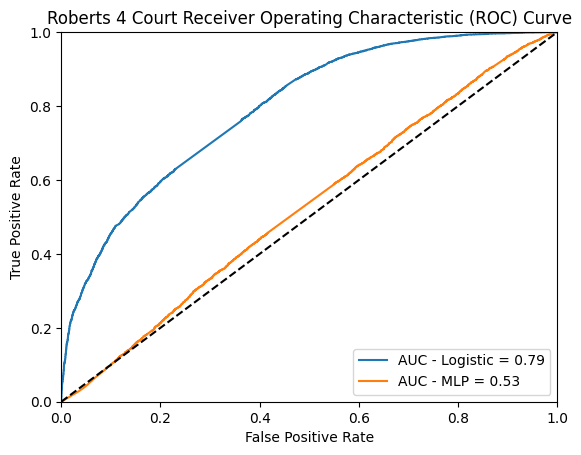

In [26]:
# rehnquist court performance - logistic regression
y_pred_proba = rehnquist_jlg.predict_proba(rehn_vect_valid)[:,1]
fpr, tpr, thresholds = roc_curve(rehnquist_label_vect_valid, y_pred_proba)
auc_score = roc_auc_score(rehnquist_label_vect_valid, y_pred_proba)

# rehnquist court performance - multi-layer perceptron
y_pred_proba2 = classif.predict_proba(rehn_vect_valid)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(rehnquist_label_vect_valid, y_pred_proba2)
auc_score2 = roc_auc_score(rehnquist_label_vect_valid, y_pred_proba2)

plt.plot(fpr, tpr, label='AUC - Logistic = %.2f' % auc_score)
plt.plot(fpr2, tpr2, label='AUC - MLP = %.2f' % auc_score2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Rehnquist 7 Court Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



# roberts court performance - logistic regression
y_pred_proba = roberts_jlg.predict_proba(rob_vect_valid)[:,1]
fpr, tpr, thresholds = roc_curve(roberts_label_vect_valid, y_pred_proba)
auc_score = roc_auc_score(roberts_label_vect_valid, y_pred_proba)

# roberts court performance - multi-layer perceptron
y_pred_proba2 = classif.predict_proba(rob_vect_valid)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(roberts_label_vect_valid, y_pred_proba2)
auc_score2 = roc_auc_score(roberts_label_vect_valid, y_pred_proba2)

plt.plot(fpr, tpr, label='AUC - Logistic = %.2f' % auc_score)
plt.plot(fpr2, tpr2, label='AUC - MLP = %.2f' % auc_score2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roberts 4 Court Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# TESTING

#### RF

In [ ]:
rf_rehn_test = RandomForestClassifier(max_depth=10, ccp_alpha=0.5, criterion='entropy', random_state=0)

rf_rehn_test.fit(rehn_vect_train, rehnquist_label_vect_train)
rf_rehn_test_preds = rf_rehn_test.predict(rehn_vect_test)

rf_rob_test.fit(rob_vect_train, roberts_label_vect_train)
rf_rob_test_preds = rf_rob_test.predict(rob_vect_test)

#### MLP

In [ ]:
classif = MLPClassifier(hidden_layer_sizes=(1024, 512, 256),
                           solver='adam', 
                           activation='relu', 
                           learning_rate='adaptive', 
                           alpha=0.001,
                           max_iter=100,
                           shuffle = True #default
                           random_state=0)

classif_rob_test.fit(rob_vect_train, roberts_label_vect_train)
classif_rob_test_preds = classif_rob_test.predict(rob_vect_test)

classif_rehn_test.fit(rehn_vect_train, rehnquist_label_vect_train)
classif_rehn_test_preds = classif_rehn_test.predict(rehn_vect_test)

#### LR

In [ ]:
lr_rehn_test = LogisticRegression(solver = "liblinear", C = 81, max_iter = 100).fit(rehn_vect_train, rehnquist_label_vect_train)
lr_rehn_test_preds = rehnquist_model_test.predict(rehn_vect_test)

lr_rob_test = LogisticRegression(solver = "liblinear", C = 51, max_iter = 100).fit(rob_vect_train, roberts_label_vect_train)
lr_rob_test_preds = lr_rob_test.predict(rob_vect_test)